In [16]:
 # Importing PIL module for image processing
from PIL import Image as PILImage 

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [17]:
#following function for saving GIFs for better visuals
def save_gif(outfile, files, fps=5, loop=0):
    
    images = [PILImage.open(file) for file in files]
    images[0].save(fp=outfile, format='GIF', append_images=images[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [18]:
#following function defines the analytical solution to the 1D underdamped harmonic oscillator problem.
def harmonic_oscillator_solution(damping, omega_0, x):
    assert damping < omega_0
    w = np.sqrt(omega_0**2 - damping**2)
    phi = np.arctan(-damping/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi + w*x)
    sin = torch.sin(phi + w*x)
    exp = torch.exp(-damping*x)
    y  = exp * 2 * A * cos
    return y

In [19]:
#Here is the fully connected network
class ConnectedNetwork(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super().__init__()
        activation = nn.Tanh
        # Define the layers of the network
        self.fcs = nn.Sequential(*[
                        nn.Linear(input_size, hidden_size),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(hidden_size, hidden_size),
                            activation()]) for _ in range(num_layers-1)])
        self.fce = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Forwarding pass through the network
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [20]:
# Constants which are required for the oscillator
damping_coefficient, omega_0 = 2, 20

In [21]:
# Generating the analytical solution over the full domain
x_values = torch.linspace(0, 1, 500).view(-1, 1)
y_values = harmonic_oscillator_solution(damping_coefficient, omega_0, x_values).view(-1, 1)


In [22]:
# here slicing out a small number of points from the left-hand side of the domain
x_data = x_values[0:200:20]
y_data = y_values[0:200:20]

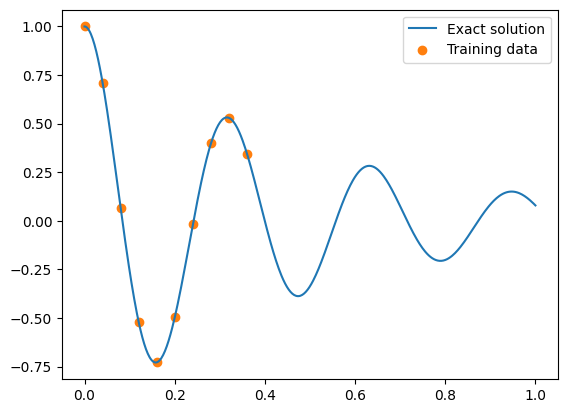

In [23]:
# Plot the exact solution and training data
plt.figure()
plt.plot(x_values, y_values, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [24]:
#plotting the training result by adding eaxct solution, predicted solution and training data
def plot_training_result(x_values, y_values, x_data, y_data, y_pred, x_physics=None):
    plt.figure(figsize=(8, 4))
    
    # Plot exact solution, predicted solution, and training data
    plt.plot(x_values, y_values, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x_values, y_pred, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    
    if x_physics is not None:
        # Plotting locations for physics loss training
        plt.scatter(x_physics, -0 * torch.ones_like(x_physics), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
        
    legend = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(legend.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065, 0.7, "Training step: %i"%(i+1), fontsize="xx-large", color="k")
    plt.axis("off")


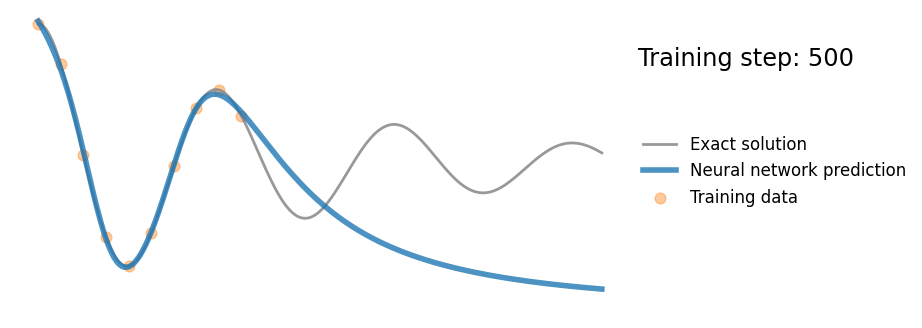

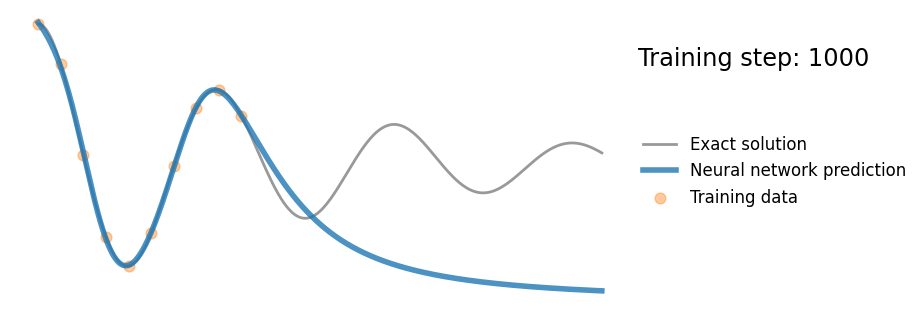

In [25]:
# Training standard/traditional neural network to fit training data
torch.manual_seed(123)
model = ConnectedNetwork(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
for i in range(1000):
    optimizer.zero_grad()
    y_pred = model(x_data)
    loss = torch.mean((y_pred - y_data)**2)  # Using here mean squared error
    loss.backward()
    optimizer.step()

    # Plot the result as training progresses for better visuals
    if (i+1) % 10 == 0:
        y_pred = model(x_values).detach()
        plot_training_result(x_values, y_values, x_data, y_data, y_pred)
        file = f"plots/nn_{i+1:08d}.png"
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 500 == 0:
            plt.show()
        else:
            plt.close("all")


In [26]:
save_gif("nn.gif", files, fps=20, loop=0)


In [27]:
x_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

In [28]:
# Constants for physics loss calculation
mu, k = 2 * damping_coefficient, omega_0**2

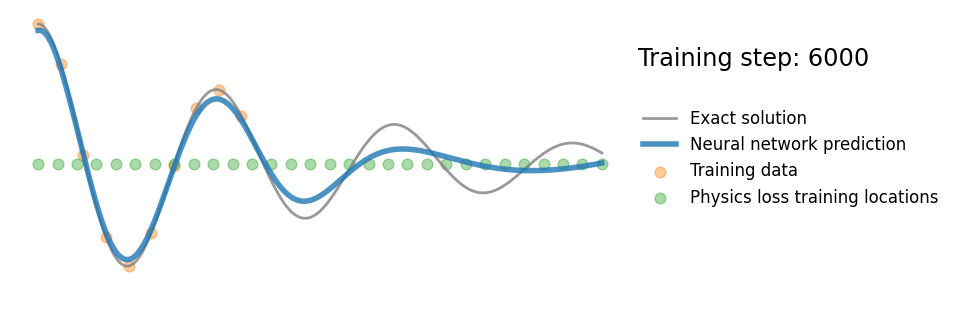

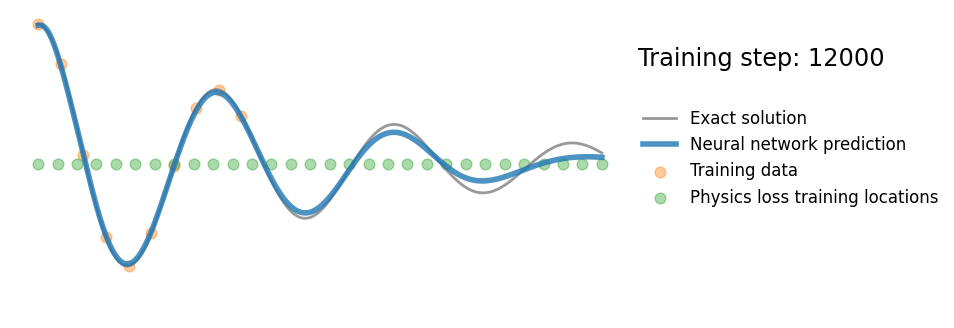

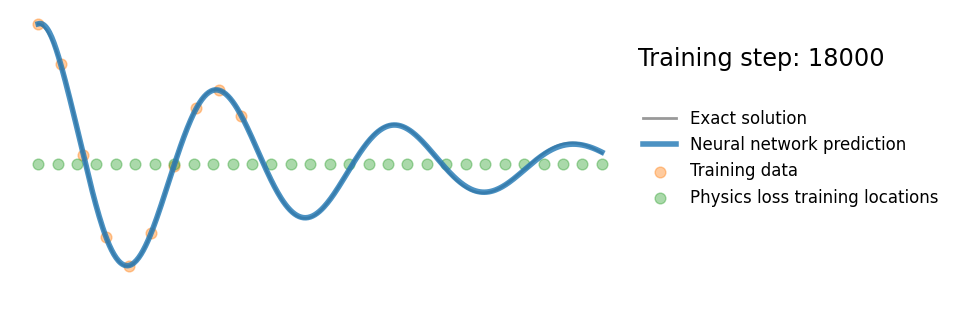

In [29]:
torch.manual_seed(123)
model = ConnectedNetwork(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
files = []
for i in range(20000):
    optimizer.zero_grad()
    
    # Computing the "data loss" as below
    y_pred = model(x_data)
    loss1 = torch.mean((y_pred - y_data)**2)  # Use mean squared error
    
    # Computing the "physics loss" as below
    y_pred_physics = model(x_physics)
    # Computing dy/dx
    dx = torch.autograd.grad(y_pred_physics, x_physics, torch.ones_like(y_pred_physics), create_graph=True)[0]  
    # Computing d^2y/dx^2
    dx2 = torch.autograd.grad(dx, x_physics, torch.ones_like(dx), create_graph=True)[0]  
    # Computing the residual of the 1D harmonic oscillator differential equation
    physics_loss = dx2 + mu*dx + k*y_pred_physics 
    loss2 = (1e-4) * torch.mean(physics_loss**2)
    
    # Backpropagating joint loss as shown below
    loss = loss1 + loss2  # Add two loss terms together
    loss.backward()
    optimizer.step()

    # Ploting the result as training progresses for better understanding
    if (i+1) % 150 == 0:
        y_pred = model(x_values).detach()
        x_physics_values = x_physics.detach()
        plot_training_result(x_values, y_values, x_data, y_data, y_pred, x_physics_values)
        file = f"plots/pinn_{i+1:08d}.png"
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 6000 == 0:
            plt.show()
        else:
            plt.close("all")

save_gif("pinn_oscillator.gif", files, fps=20, loop=0)